# Simulation of Relevance Profiles

This notebook aims to accurately simulate relevance profiles using the [jMetalPy framework](https://github.com/jMetal/jMetalPy/tree/main), based on the paper by [Roitero et. al (2019)](https://dl.acm.org/doi/10.1145/3357384.3358123).

## Initial imports

Required libraries used throughout the notebook. Of note is the jMetalPy framework that is crucial for the simulation.

In [11]:
# Standard Library Imports
import copy
import math
import random
import hashlib
from abc import ABC
from typing import List

# Third-Party Imports
import matplotlib.pyplot as plt
import numpy as np

# jMetalPy Framework Imports
from jmetal.operator import PMXCrossover
from jmetal.algorithm.multiobjective.nsgaii import NSGAII
from jmetal.core.operator import Crossover, Mutation
from jmetal.core.problem import IntegerProblem
from jmetal.core.solution import IntegerSolution, Solution
from jmetal.util.termination_criterion import StoppingByEvaluations


## Definitions of helper functions

This includes the DCG and anDCG ([Järvelin et. al (2002)](http://doi.acm.org/10.1145/582415.582418)) functions, which are used to evaluate a particular simulated ranking.
 
The relevance function, instead, uses an exponential to define the probabilities of each possible relevance judgement at a given rank.

In [12]:
def compute_DCG(ranking: List[int]) -> List[float]:
    """ Computes DCG for a given ranking. """
    
    res = copy.deepcopy(ranking)
    for i in range(len(ranking)):
        if i > 0:
            res[i] = res[i - 1] + ranking[i] / math.log2(i + 1)
    return res


def compute_anDCG(relevance_list: List[int], k: int = None) -> float:
    """ Computes average nDCG for the fitness function. """
    
    if k is None:
        k = len(relevance_list)
        
    relevance_list = relevance_list[:k]
    ideal_solution = sorted(relevance_list, reverse=True)
    
    l = len(relevance_list)
    
    dcg_vals = compute_DCG(ranking=relevance_list)
    idcg_vals = compute_DCG(ranking=ideal_solution)
    
    dwp_vals = [dcg_vals[i] / idcg_vals[i] if idcg_vals[i] != 0 else 0 for i in range(l)]
    return sum(dwp_vals) / l

def get_relevance_judgement(rank: int, max_rank: int, min_rel: int, max_rel: int, system_id: int) -> int:
    """ Returns a randomised relevance judgement for a given rank, using a rank-based exponential curve. """
    
    # decay_factors = [2.0, 5.0, 10.0, 20.0, 50.0]
    # decay = decay_factors[system_id % len(decay_factors)]    
    # probs = np.array([
    #      np.exp(-(rel + 1 + decay)%(max_rel + 1) * (rank - max_rank / decay) / (max_rank / 5 )) for rel in range(min_rel, max_rel + 1)
    # ])
    probs = np.array([
         np.exp(-(rel + 1) * (rank - max_rank / 10) / (max_rank / 5 )) for rel in range(min_rel, max_rel + 1)
    ])
    probs /= probs.sum()
    return np.random.choice(range(max_rel + 1), p=probs)

## Definition of custom problem

To use the jMetalPy framework, we must define a custom profile for what we are trying to achieve: simulation of ranking profiles. To do so, we set several constraints for our solutions: length, minimum and maximum value of a judgement, and the quantity of each judgement. A variable is defined to be the profile generated for a particular topic and system. Many possible profiles are generated, of which some are chosen based on the objective. In this case, the objective is to minimise the difference between the target anDCG and the anDCG of a particular ranking. The ideal ranking is calculated using the per-judgement constraints given by R.

In [13]:
class RelevanceProfileProblem(IntegerProblem, ABC):
    def __init__(self, list_length: int, min_relevance: int, max_relevance: int, target_fitness: float, R: List[int]):
        super().__init__()
        self.length = list_length
        self.lower_bound = [min_relevance] * self.length
        self.upper_bound = [max_relevance] * self.length
        self.number_of_variables = self.length
        self.number_of_objectives = 1
        self.number_of_constraints = len(R)
        self.target_fitness = target_fitness
        self.R = R
        self.system_id = -1
        
    def name(self) -> str:
        return "Relevance Profile Problem, inherits Integer Problem"
        
    def number_of_constraints(self) -> int:
        return self.number_of_constraints
    
    def number_of_objectives(self) -> int:
        return self.number_of_objectives

    def create_solution(self) -> IntegerSolution:
        """ Creates an initial solution for the problem. """
        self.system_id += 1
        
        values = [0] * self.length
        relevance_counts = np.zeros_like(self.R)
        
        # Randomly generate a profile using the rank-based exponential, ensuring the constraints are met
        for idx in range(self.length):
            while True:
                rel = get_relevance_judgement(rank=idx, max_rank=self.length, min_rel=self.lower_bound[0], max_rel=self.upper_bound[0], system_id=self.system_id)
                
                if relevance_counts[rel] < self.R[rel]:
                    break
            
            relevance_counts[rel] += 1
            values[idx] = rel
            
        solution = IntegerSolution(
            lower_bound=self.lower_bound,
            upper_bound=self.upper_bound,
            number_of_objectives=self.number_of_objectives,
            number_of_constraints=self.number_of_constraints
        )
        solution.variables = values
        return solution
    
    def evaluate(self, solution: IntegerSolution) -> None:
        """ Evaluate the solution based on average nDCG with respect to target fitness. """
        
        # Count the number of items for each relevance judgement 
        unique_vals, relevance_counts = np.unique(solution.variables, return_counts=True)
        full_range = np.arange(self.lower_bound[0], self.upper_bound[0] + 1)
        count_dict = dict(zip(unique_vals, relevance_counts))
        relevance_counts = np.array([count_dict.get(i, 0) for i in full_range])
        
        # Constraint check
        if np.any(relevance_counts > self.R):
            solution.objectives[0] = float('inf')
            return
        
        # Compute the anDCG difference between the simulated profile and the target
        anDCG = compute_anDCG(relevance_list=solution.variables)
        solution.objectives[0] = abs(self.target_fitness - anDCG)

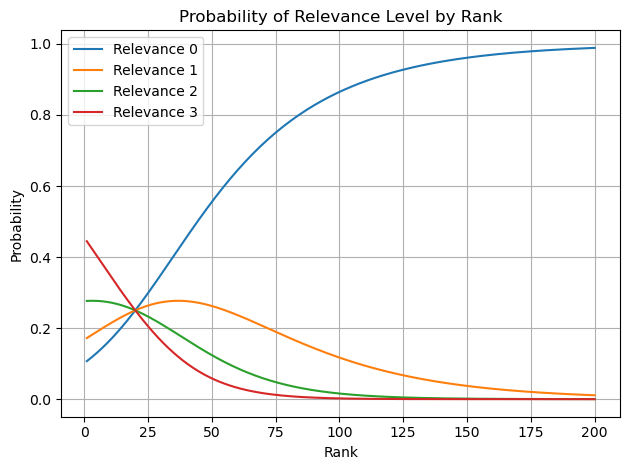

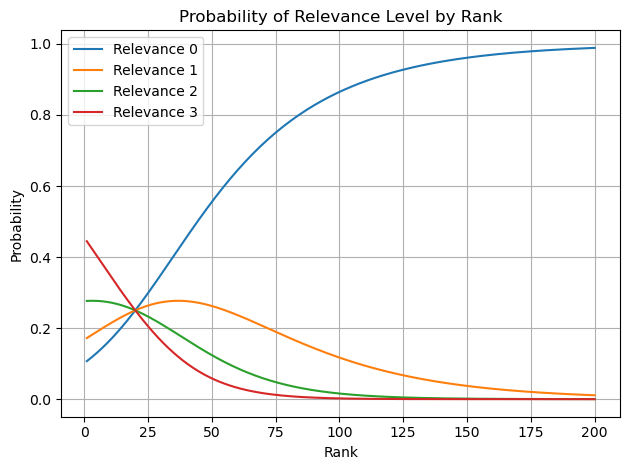

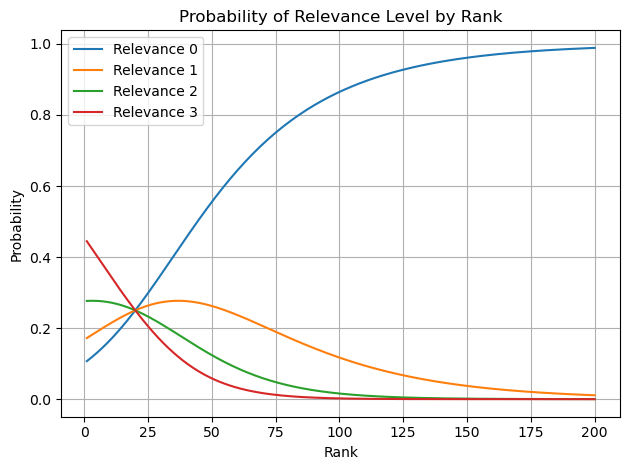

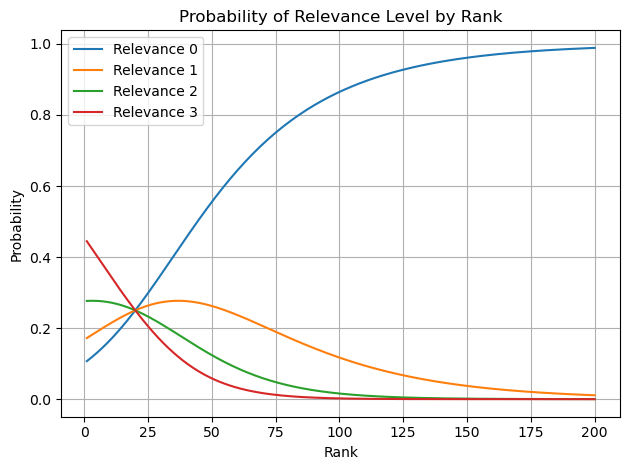

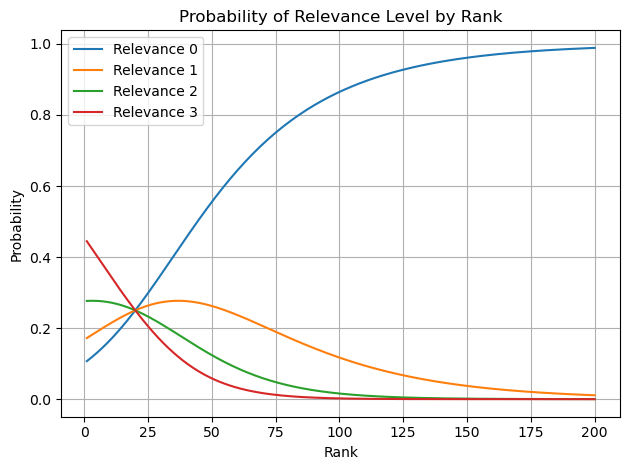

In [14]:
def get_probs(rank, max_rank, min_rel, max_rel, system_id):
    # decay_factors = [2.0, 5.0, 10.0, 20.0, 50.0]
    # decay = decay_factors[system_id % len(decay_factors)]
    # 
    # probs = np.array([
    #      np.exp(-(rel + 1 + decay)%(max_rel + 1) * (rank - max_rank / decay) / (max_rank / 5 )) for rel in range(min_rel, max_rel + 1)
    # ])
    probs = np.array([
     np.exp(-(rel + 1) * (rank - max_rank / 10) / (max_rank / 5 )) for rel in range(min_rel, max_rel + 1)
    ])
    probs /= probs.sum()
    return probs

max_rank = 200
max_rel = 3
ranks = np.arange(1, max_rank + 1)

prob_matrix = np.zeros((max_rank, max_rel + 1))  # shape: (rank, rel)
for system_id in range(5):
    for i, rank in enumerate(ranks):
        prob_matrix[i] = get_probs(rank, max_rank, 0, max_rel, system_id)
    
    for rel in range(max_rel + 1):
        plt.plot(ranks, prob_matrix[:, rel], label=f'Relevance {rel}')
    plt.title('Probability of Relevance Level by Rank')
    plt.xlabel('Rank')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Definition of custom crossover and mutation functions

To generate many different solutions in a randomised fashion, we must perturb the initial profiles generated by the problem. As such, we apply a custom crossover, which either adds or multiplies items from two parent solutions, or a custom mutation, which either randomly swaps two items in a solution or adds a random quantity to an item.

In [15]:
class CustomCrossover(Crossover, ABC):
    def __init__(self, L: int):
        super().__init__(probability=1.0)  # Always apply
        self.L = L
        
    def get_name(self) -> str:
        return "Custom Crossover for ranking profiles. "
    
    def get_number_of_parents(self) -> int:
        return 2
    
    def get_number_of_children(self) -> int:
        return 2

    def execute(self, parents: List[Solution] )-> List[Solution]:
        """ Executes the crossover, by either adding or multiplying items from two parent solutions. """
        parent1, parent2 = parents[0].variables, parents[1].variables
        child1, child2 = [], []
        for a, b in zip(parent1, parent2):
            if random.random() < 0.5:
                c1 = (a + b) % (self.L + 1)
                c2 = (a * b) % (self.L + 1)
            else:
                c1 = (a * b) % (self.L + 1)
                c2 = (a + b) % (self.L + 1)
            child1.append(c1)
            child2.append(c2)

        offspring1 = copy.deepcopy(parents[0])
        offspring2 = copy.deepcopy(parents[1])
        offspring1.variables = child1
        offspring2.variables = child2
        return [offspring1, offspring2]

class CustomMutation(Mutation, ABC):
    def __init__(self, L: int):
        super().__init__(probability = 1.0)
        self.L = L
        
    def get_name(self) -> str:
        return "Custom Mutation for ranking profiles. "

    def execute(self, solution: Solution) -> Solution:
        """ Executes the mutation, by randomly swapping two items in a solution or adding a random quantity to an item. """
        for i in range(len(solution.variables)):
            if random.random() < 0.5:
                # Swap the selected index with another random index
                j = random.randint(0, len(solution.variables) - 1)
                solution.variables[i], solution.variables[j] = solution.variables[j], solution.variables[i]
            else:
                # Add a random quantity mod L + 1 to the selected index
                solution.variables[i] = (solution.variables[i] + random.randint(0, self.L)) % (self.L + 1)
        return solution

## Definition of helper functions

These functions help to compute some graphs that allow a better understanding of simulation results, as well as generating R for each topic

In [16]:
def store_topic_profiles(result, num_topics: int) -> dict[int, List[int]]:
    """ Stores the profiles indexed by topic into a dictionary. """
    
    topic_profiles = {i: [] for i in range(num_topics)}
    
    for idx, sol in enumerate(result):
        topic_id = idx % num_topics
        topic_profiles[topic_id].append(sol.variables)
        
    return topic_profiles

def compute_anDCG_matrix(problem: RelevanceProfileProblem, result, list_length: int) -> List[List[int]]:
    """ Computes the anDCG matrix (profile by rank) for a given problem. This gives the anDCG score up to a given rank, for a particular profile. """
    
    profiles = [sol.variables for sol in result]
    ndcg_matrix = np.zeros((len(profiles), list_length))
    for i, profile in enumerate(profiles):
        for j in range(1, list_length):
            ndcg_matrix[i][j] = abs(
                problem.target_fitness - compute_anDCG(relevance_list=profile, k=j)
            )
            
    return ndcg_matrix

In [17]:
def write_results_to_files(result):
    """ Writes results to FUN and VAR files. """
    
    with open('FUN', "a") as f_fun:
        for sol in result:
            f_fun.write(" ".join(map(str, sol.objectives)) + "\n")

    with open('VAR', "a") as f_var:
        for sol in result:
            f_var.write(" ".join(map(str, sol.variables)) + "\n")

## Main simulation loop

Define parameters and run the simulation using the NSGA-II algorithm from jMetalPy. Store results for graphing.

In [32]:
# Simulation parameters
num_runs = 20
min_relevance = 0
max_relevance = 3
list_length = 50
num_topics = 50
R = [list_length, 30, 15, 10]
L = max_relevance - min_relevance

# Metrics and data storage
errors = []
all_target_fitnesses = []
all_anDCG_matrices = []
all_profiles = []

# Clear output files before starting the simulation
open('VAR', "w").close()
open('FUN', "w").close()

# Main simulation loop
for run in range(num_runs):
    target_fitness = np.random.uniform(0.8, 0.8)
    all_target_fitnesses.append(target_fitness)

    # Set up problem and algorithm
    problem = RelevanceProfileProblem(
        list_length=list_length,
        min_relevance=min_relevance,
        max_relevance=max_relevance,
        target_fitness=target_fitness,
        R=R
    )

    algorithm = NSGAII(
        problem=problem,
        population_size=num_topics,
        offspring_population_size=num_topics,
        mutation=CustomMutation(L=L),
        crossover=CustomCrossover(L=L),
        termination_criterion=StoppingByEvaluations(max_evaluations=10000)
    )

    algorithm.run()
    result = algorithm.result()
    
    # Store fitness errors
    errors.extend([sol.objectives[0] for sol in result])

    # Store topic profiles
    topic_profiles = store_topic_profiles(result=result, num_topics=num_topics)
    
    # Store all profiles
    all_profiles.extend([sol.variables for sol in result])

    # Compute anDCG for each profile, at each rank
    anDCG_matrix = compute_anDCG_matrix(problem=problem, result=result, list_length=list_length)
    all_anDCG_matrices.append(np.mean(anDCG_matrix, axis=0))

    # Append results to FUN and VAR files
    write_results_to_files(result=result)
    

[2025-06-09 10:53:22,576] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-06-09 10:53:22,660] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-06-09 10:53:22,676] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-06-09 10:53:22,676] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-06-09 10:53:27,633] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-06-09 10:53:27,934] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-06-09 10:53:27,997] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-06-09 10:53:28,013] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-06-09 10:53:28,013] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-06-09 10:53:32,381] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-06-09 10:53:32,669] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-06-09 10:53:32,741] [jm

# Graphs

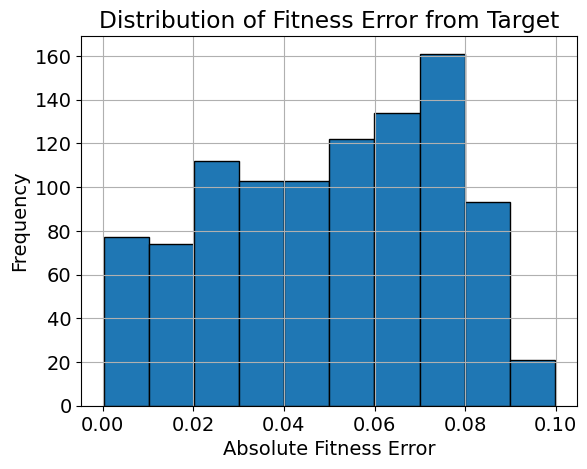

In [33]:
plt.hist(errors, edgecolor='black')
plt.title("Distribution of Fitness Error from Target")
plt.xlabel("Absolute Fitness Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

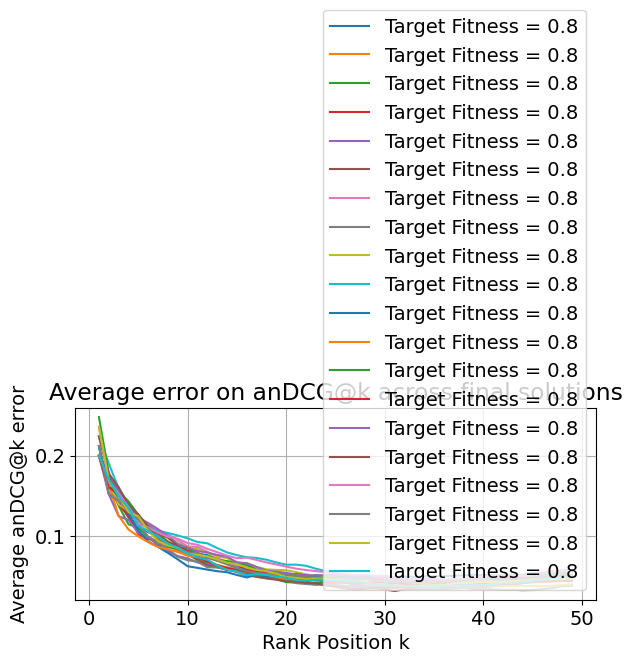

In [34]:
for i in range(num_runs):
    plt.plot(range(1, list_length), all_anDCG_matrices[i][1:], label=f'Target Fitness = {all_target_fitnesses[i]}')

plt.title("Average error on anDCG@k across final solutions")
plt.xlabel("Rank Position k")
plt.ylabel("Average anDCG@k error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

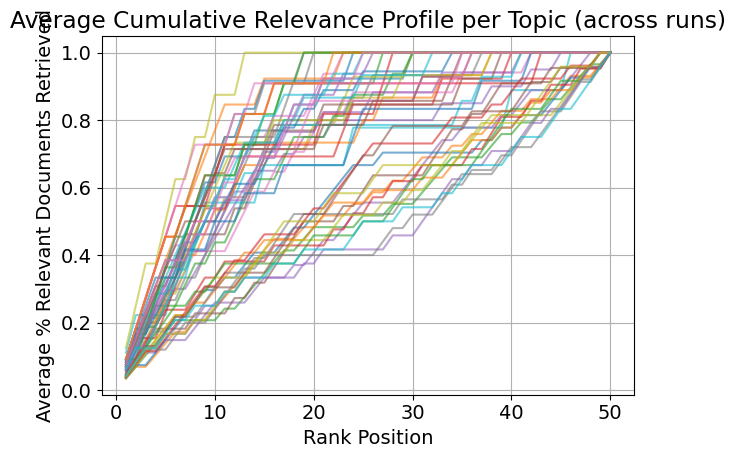

In [35]:
for topic_id in range(num_topics):
    profiles = topic_profiles[topic_id]
    binary_profiles = [[1 if rel > 0 else 0 for rel in profile] for profile in profiles]
    total_relevant = np.mean([sum(profile) for profile in binary_profiles])

    cumrels = [np.cumsum(profile) for profile in binary_profiles]
    cumrels_avg = np.mean(cumrels, axis=0)

    recall_curve = cumrels_avg / total_relevant
    plt.plot(range(1, list_length + 1), recall_curve, alpha=0.6)

plt.title("Average Cumulative Relevance Profile per Topic (across runs)")
plt.xlabel("Rank Position")
plt.ylabel("Average % Relevant Documents Retrieved")
plt.grid(True)
plt.tight_layout()
plt.show()

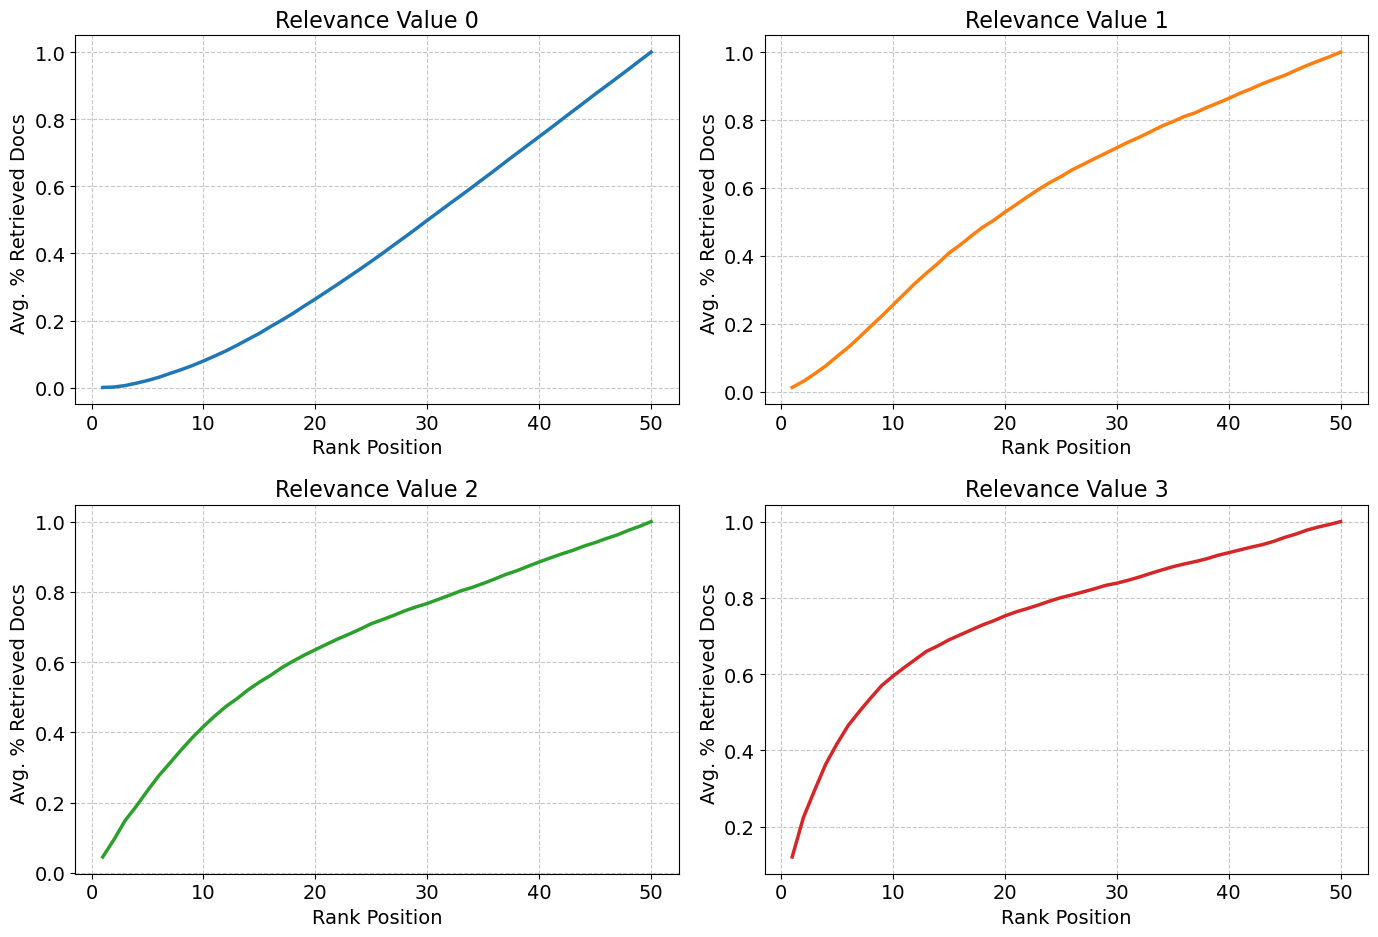

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor='white')
plt.rcParams.update({'font.size': 14})

for rel_val in range(0, 4):
    row = rel_val // 2
    col = rel_val % 2
    ax = axes[row][col]

    binary_profiles = [[1 if rel == rel_val else 0 for rel in profile] for profile in all_profiles]
    total_relevant = np.mean([sum(profile) for profile in binary_profiles])

    cumrels = [np.cumsum(profile) for profile in binary_profiles]
    cumrels_avg = np.mean(cumrels, axis=0)

    recall_curve = cumrels_avg / total_relevant if total_relevant > 0 else np.zeros_like(cumrels_avg)
    
    ax.plot(range(1, list_length + 1), recall_curve, color='C'+str(rel_val), lw=2.5)
    ax.set_title(f"Relevance Value {rel_val}", fontsize=16)
    ax.set_xlabel("Rank Position", fontsize=14)
    ax.set_ylabel("Avg. % Retrieved Docs ", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_facecolor('white')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [23]:
from collections import defaultdict

def generate_hashes(n):
    return [hashlib.sha256(f"item_{i}".encode()).hexdigest()[:8] for i in range(n)]

def assign_hashes_to_profile(profile, relevance_to_hashes):
    used_hashes = set()
    hash_pool = {r: list(hs) for r, hs in relevance_to_hashes.items()}
    for r in hash_pool:
        random.shuffle(hash_pool[r])

    result = []
    for relevance in profile:
        candidates = hash_pool[relevance]
        if not candidates:
            raise ValueError(f"No more hashes available for relevance {relevance}")
        chosen_hash = candidates.pop()
        used_hashes.add(chosen_hash)
        result.append(chosen_hash)
    return result


max_counts = []
total_counts  = 0
# Generate an ideal solution based on the constraints
for relevance_level, count in reversed(list(enumerate(R))):
    max_counts += [relevance_level] * count
    total_counts += count

hashes = generate_hashes(total_counts)
hash_to_relevance = dict(zip(hashes, max_counts))

relevance_to_hashes = defaultdict(list)
for h, r in hash_to_relevance.items():
    relevance_to_hashes[r].append(h)

hashed_profiles = [assign_hashes_to_profile(profile, relevance_to_hashes) for profile in all_profiles]
system_num = -1
for p_idx, (hashed_profile, profile) in enumerate(zip(hashed_profiles, all_profiles)):
    topic_num = p_idx % num_topics
    if topic_num == 0:
        system_num += 1
        file = open(f"./simulated_data/system_{system_num}.csv", "w+")
        file.write("topic,doc,score,rel\n")
    else:
        file = open(f"./simulated_data/system_{system_num}.csv", "a+")
    for i in range(len(profile)):
        file.write(f"{topic_num},{hashed_profile[i]},0,{profile[i]}\n")

In [24]:
def tau(x, y):
    n = len(x)

    tau_num = 0.0
    tau_den = 0.0

    if n < 2:
        print("Returning 0!")
        return 0.0

    for i in range(n):
        for j in range(i + 1, n):
            concordance = np.sign(x[i] - x[j]) * np.sign(y[i] - y[j])


            tau_num += concordance * 1.0
            tau_den += 1.0

    return tau_num / tau_den

In [26]:
import csv

def read_file(filename):
    """Reads a CSV file and returns topic-wise document entries."""
    result = {}
    with open(filename, mode='r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for line in reader:
            topic = int(line[0])
            entry = {'doc': line[1], 'score': float(line[2]), 'rel': int(line[3])}
            result.setdefault(topic, []).append(entry)
    return result


def get_common_items(ranking_1, ranking_2):
    """Filters rankings to retain only documents common to both."""
    filtered_1, filtered_2 = {}, {}
    for topic in ranking_1:
        if topic in ranking_2:
            docs1 = {entry['doc'] for entry in ranking_1[topic]}
            docs2 = {entry['doc'] for entry in ranking_2[topic]}
            common_docs = docs1 & docs2
            filtered_1[topic] = [entry for entry in ranking_1[topic] if entry['doc'] in common_docs]
            filtered_2[topic] = [entry for entry in ranking_2[topic] if entry['doc'] in common_docs]
    return filtered_1, filtered_2

Status update. Topic: 0, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 1, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 2, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 3, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 4, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 5, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 6, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 7, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 8, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 9, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 10, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 11, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 12, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 13, file 1: system_0.csv, file 2: system_1.csv
Status update. Topic: 14, file 1: system_0.c

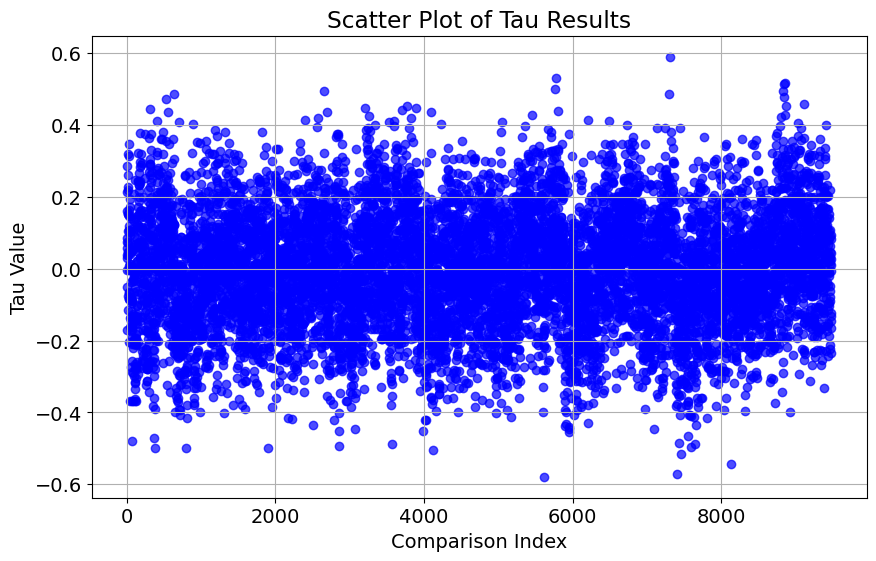

In [30]:
from os import listdir
from os.path import isfile, join
from itertools import combinations

folder = 'simulated_data'
files = [f for f in listdir(folder) if isfile(join(folder, f))]

results = []

for f1, f2 in combinations(files, 2):
    res_1 = read_file(f'{folder}/{f1}')
    res_2 = read_file(f'{folder}/{f2}')
    filtered_1, filtered_2 = get_common_items(res_1, res_2)
    
    for topic in list(filtered_1.keys()):
        items_1 = [item["doc"] for item in filtered_1[topic]]
        items_2 = [item["doc"] for item in filtered_2[topic]]

        index_map_1 = {doc: i for i, doc in enumerate(items_1, start=1)}
        index_map_2 = {doc: i for i, doc in enumerate(items_2, start=1)}
        sorted_X = [index_map_1[doc] for doc in items_1]
        sorted_Y = [index_map_2[doc] for doc in items_1]

        results.append(tau(sorted_X, sorted_Y))
        
results = np.array(results)
results.flatten()
plt.figure(figsize=(10, 6))
plt.scatter(range(len(results)), results, alpha=0.7, color='blue')
plt.title('Scatter Plot of Tau Results')
plt.xlabel('Comparison Index')
plt.ylabel('Tau Value')
plt.grid(True)
plt.show()